In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from typing import List
from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, TEST_EXCLUDING_DIS, TEST_RESTRICTED_DIS
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import obtain_filtered_triples
from nb_utils.eval_utils import split_test_triples_conditioned_on_ent_property, split_train_ents_by_existance_of_properties
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import make_results_dict_all_rel, make_results_dict_rel_breakdown
from nb_utils.eval_utils import compute_node_degrees_in_out

Change this cell to generate a report for other datasets/models:

In [4]:
SHARED_DATA_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")
PROJ_DATA_DIR = Path("../data/")

In [5]:
# model registry
ROTATE = "rotate"
BIOBLP_D = "bioblp_d"

MODEL_ID_rotate = 'rotate-otxtubeb' 
MODEL_ID_bioblpd = 'bioblpd-38uz9fjs'

MODELS = {
    ROTATE: MODEL_ID_rotate,
    BIOBLP_D: MODEL_ID_bioblpd
}

In [6]:
model_registry_basedir = SHARED_DATA_DIR.joinpath(f"models")
model_registry_paths = {v: model_registry_basedir.joinpath(f"{v}") for v in MODELS.values()}
model_registry_paths

{'rotate-otxtubeb': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb'),
 'bioblpd-38uz9fjs': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs')}

In [7]:
graph_path = PROJ_DATA_DIR.joinpath('biokgb/graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'
dummy_triples = 'biokg.links-dummy.csv'

##  Loading model and data

make a keyword based switching statement b/w rotate and bioblp-d

In [8]:
def load_kge_model(model_base_path):
    '''model = load_kge_model(model_base_path = model_registry_paths[MODEL_ID])
    '''
    model_path = model_base_path.joinpath("trained_model.pkl")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_path, map_location=torch.device(device))
    #train = TriplesFactory.from_path_binary(model_base_path.joinpath("training_triples"))
    return model
    

In [9]:
# load training splits
MODEL_ID = MODELS.get(ROTATE)    
train = TriplesFactory.from_path_binary(model_registry_paths[MODEL_ID].joinpath("training_triples"))

creating a dummy set of triples for unit testing purposes

In [10]:
DUMMY = 'dummy'
dummy_triples = 'biokg.links-dummy.csv'
if not graph_path.joinpath(dummy_triples).exists:
    print('Slicing test triples to create a batch of dummy triples')
    dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
    dummy_df.to_csv(graph_path.joinpath(dummy_triples), sep="\t", index=None, header=None)

In [11]:
valid, test, dummy = [TriplesFactory.from_path(graph_path.joinpath(f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples, dummy_triples)]

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

Create test sets: 
D; D_b, D_r; 

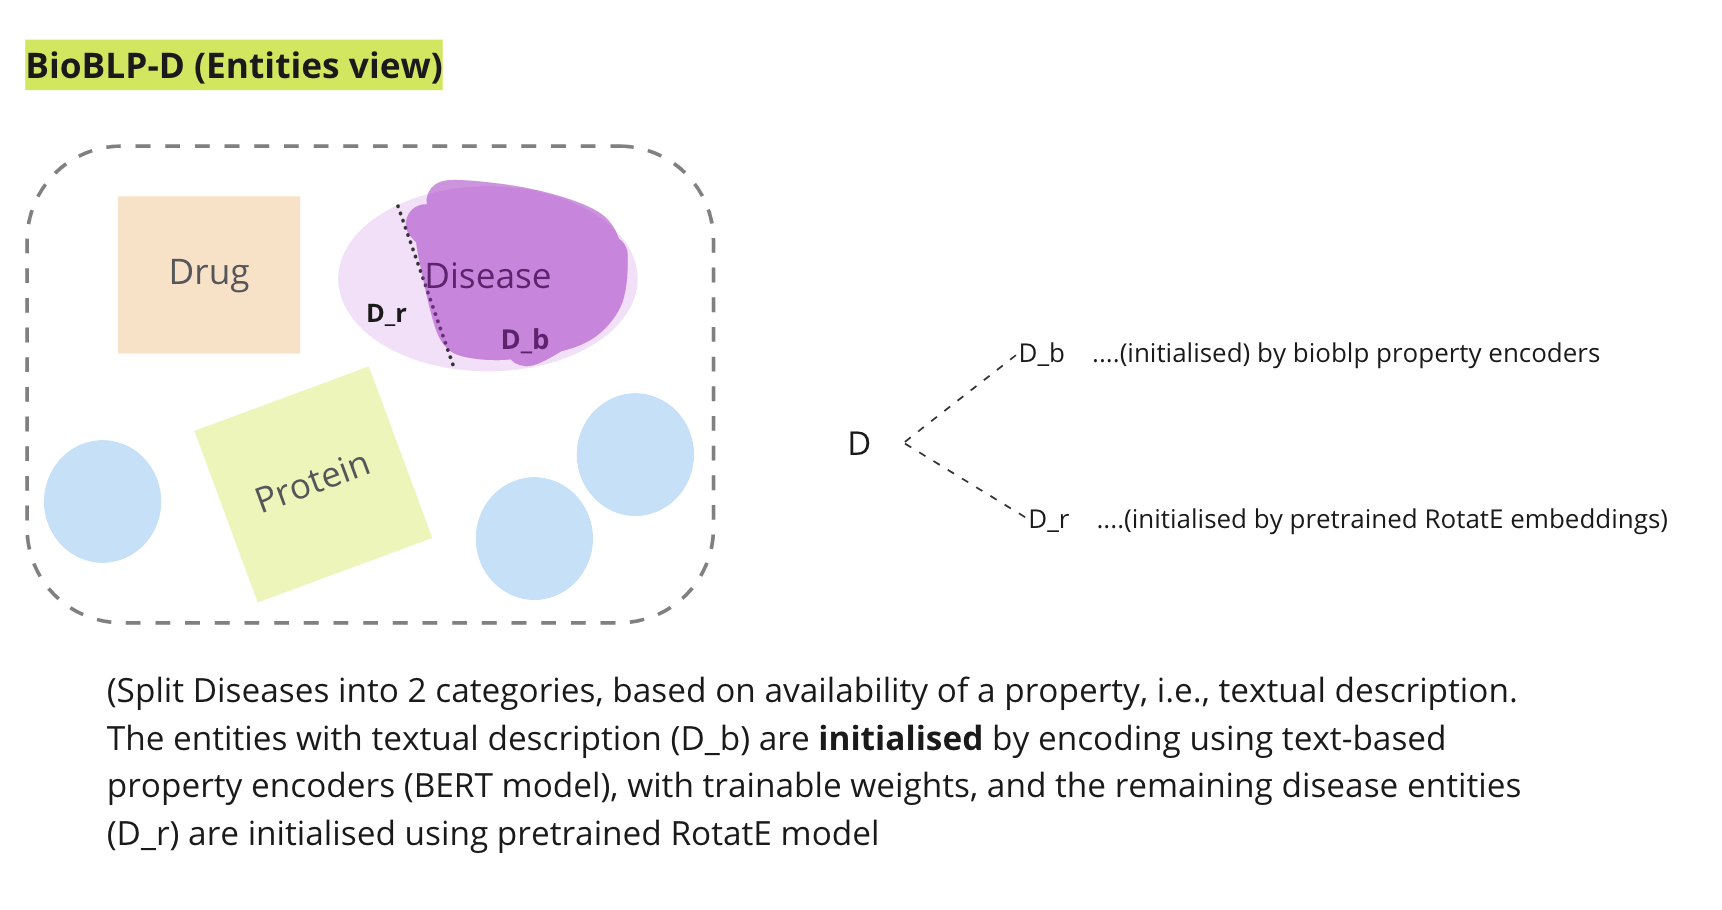

In [292]:
from IPython.display import Image
Image('data/imgs/eval_split_entity_view.png', width=600)

From stats below, we see that all biokgb entities surprisingly have a relation - > D_r is an empty set. -> This is because we used the name of disease as decription in places where it was missing


In [12]:
disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name.tsv")
disease_metadata_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg.metadata.disease.tsv")

# create a subset of biokg entities of type Disease 
diseases = pd.read_csv(disease_metadata_path, sep="\t", names=["disease", "rel", "node_type"])
disease_set = set(diseases.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal): {len(disease_set)}")

# create a set of disease entities for which we have text descriptions
disease_w_desc_df = pd.read_csv(disease_descr_path, sep="\t", header=0, names=["disease", "desc"])
disease_desc_set = set(disease_w_desc_df.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: {len(disease_desc_set)}")


# Disease entities in larger biokg (pre-benchmark removal): 11347
# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: 11347


In [13]:
# Side note: all disease entities in Biokgb have decscriptions; because missing values were plugged with disease names
disease_w_desc_df["len"] = disease_w_desc_df["desc"].str.len()
disease_w_desc_df.len.describe()

count    11347.000000
mean       149.042743
std        156.370558
min          5.000000
25%         37.000000
50%         70.000000
75%        231.000000
max       1076.000000
Name: len, dtype: float64

#### define test sets
The figure below demonstrates how we obtain the various test sets

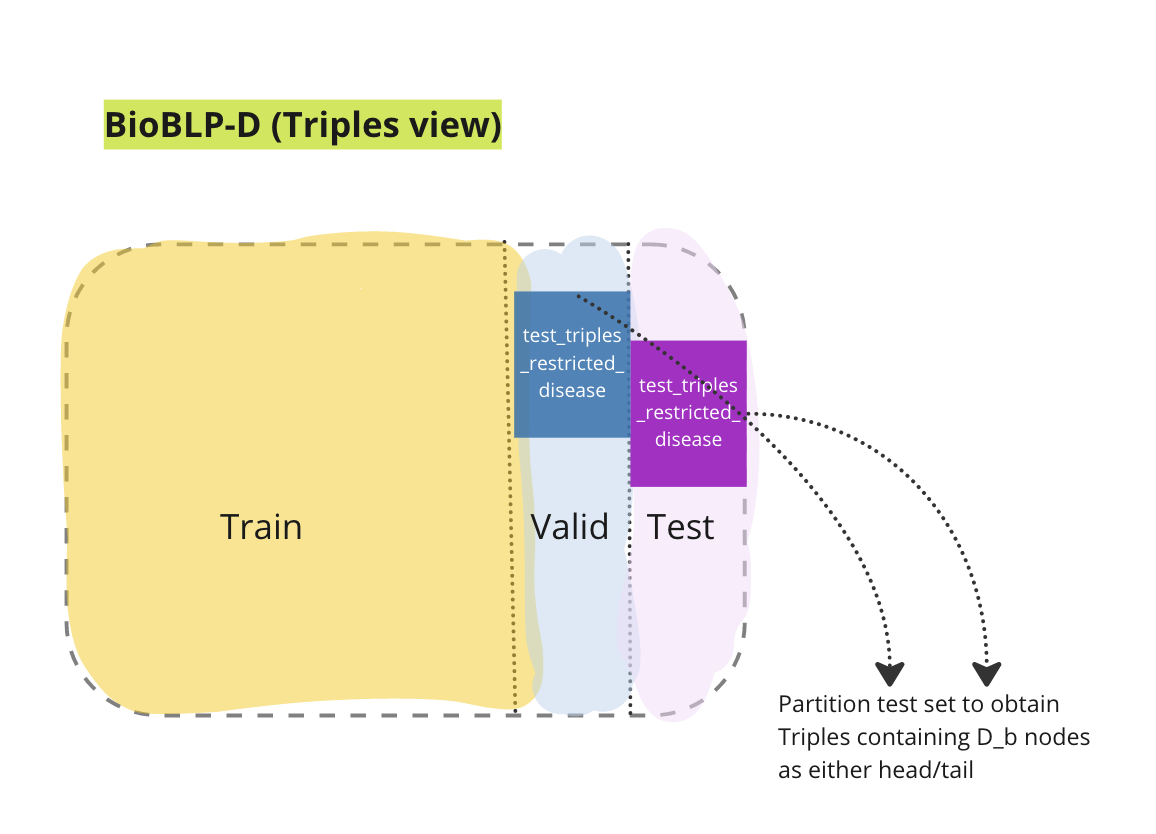

In [295]:
Image('data/imgs/eval_split_triples_view.png', width=500)

In [14]:
test_triples_incl_dis_prop, test_triples_excl_dis_prop = split_test_triples_conditioned_on_ent_property(train_triples=train, 
                                                                                                        typed_ent_set=disease_set, 
                                                                                                        typed_ent_with_prop_set=disease_desc_set,
                                                                                                        test_triples=test)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [15]:
# relations containing diseases include -> 
dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
dis_assoc_rels

{'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'PROTEIN_DISEASE_ASSOCIATION': 14}

In [293]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
print(f"# test triples with disease nodes: {test_triples_incl_dis_prop.num_triples}")
print(f"# test triples without disease nodes: {test_triples_excl_dis_prop.num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with disease nodes: 17063
# test triples without disease nodes: 168164


In [294]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    TEST_RESTRICTED_DIS: test_triples_incl_dis_prop,
    TEST_EXCLUDING_DIS: test_triples_excl_dis_prop,
    DUMMY: dummy, 
}

TEST_SET_LIST = [TEST_RESTRICTED_DIS, TEST_EXCLUDING_DIS, TEST, VALID]


# Evaluation

wandb logging

In [ ]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_NAME = "bioblp-jupyter-trial"


sanity check logic for experiment run with wandb logging

In [22]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}

#trial_func_kwargs = {"x": 1, "y": 2} 
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

## analyse effect of node degree?
1. compute a degree table for entities in train

In [354]:
training_df = pd.DataFrame(train.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
training_df[:2]

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1479277
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1591211


In [355]:
# not a nec step, but to ease computation, let's restrict the triples to disease node containg triples
#dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
#training_df = training_df[training_df[COL_EDGE].isin(list(dis_assoc_rels.keys()))]
training_df.rel.value_counts()

DDI                            906535
PROTEIN_PATHWAY_ASSOCIATION    205871
PPI                             93643
PROTEIN_DISEASE_ASSOCIATION     89804
MEMBER_OF_COMPLEX               71035
DRUG_DISEASE_ASSOCIATION        53426
COMPLEX_IN_PATHWAY              19615
COMPLEX_TOP_LEVEL_PATHWAY       12488
DPI                              7860
DRUG_TARGET                      5714
DISEASE_GENETIC_DISORDER         4339
DRUG_PATHWAY_ASSOCIATION         4244
RELATED_GENETIC_DISORDER         3450
DISEASE_PATHWAY_ASSOCIATION      2945
DRUG_ENZYME                       528
DRUG_TRANSPORTER                  222
DRUG_CARRIER                       90
Name: rel, dtype: int64

In [357]:
node_train_degree_df = compute_node_degrees_in_out(training_df)
node_train_degree_dict = pd.Series(node_train_degree_df.degree.values,index=node_train_degree_df.ent).to_dict()

Now we attach the training node degrees against the disease entities in Test triples

In [361]:
# now bucket the test triples according to node degree
def retrieve_node_degree(node, node2degree_dict):
    return node2degree_dict.get(node, 0)

test_triples_dis_df = pd.DataFrame(test_triples_incl_dis_prop.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
test_triples_dis_df["src_training_degree"] = test_triples_dis_df["src"].apply(lambda x: retrieve_node_degree(x, node_train_degree_dict))
test_triples_dis_df["tgt_training_degree"] = test_triples_dis_df["tgt"].apply(lambda x: retrieve_node_degree(x, node_train_degree_dict))
test_triples_dis_df.head()

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt,src_training_degree,tgt_training_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,148.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,148.0,56.0
2,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D009062,148.0,180.0
3,A0A0R4IKU3,PROTEIN_DISEASE_ASSOCIATION,D009361,4.0,599.0
4,A0A0R4IQZ2,PROTEIN_DISEASE_ASSOCIATION,D000686,2.0,38.0


In [363]:
test_triples_dis_df.rel.unique()

array(['PROTEIN_DISEASE_ASSOCIATION', 'DISEASE_GENETIC_DISORDER',
       'DISEASE_PATHWAY_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'],
      dtype=object)

In [365]:
test_triples_dis_df[test_triples_dis_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION',
                                                           'DRUG_DISEASE_ASSOCIATION'])].tgt_training_degree.describe()

count    16509.000000
mean       308.531407
std        427.112926
min          1.000000
25%         48.000000
50%        152.000000
75%        386.000000
max       2448.000000
Name: tgt_training_degree, dtype: float64

In [366]:
test_triples_dis_df[test_triples_dis_df[COL_EDGE].isin(['DISEASE_GENETIC_ORDER',
                                                        'DISEASE_PATHWAY_ASSOCIATION'])].tgt_training_degree.describe()

count     293.000000
mean       60.511945
std        94.425139
min         1.000000
25%        10.000000
50%        26.000000
75%        78.000000
max      1168.000000
Name: tgt_training_degree, dtype: float64

### average performance predicting the node which has an entity degree of x

Let's focus only on 'PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION' which have more support.

The disease entity is the tail entity in these triples

In [369]:
restricted_rels_for_tail_eval = ['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION']
test_triples_dis_tail_df = test_triples_dis_df.loc[test_triples_dis_df[COL_EDGE].isin(restricted_rels_for_tail_eval)]
test_triples_dis_tail_df[:2]

,src,rel,tgt,src_training_degree,tgt_training_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,148.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,148.0,56.0


In [370]:
def get_unique_endpoint_entities_in_testset_of_given_degree(test_df, degree, node_endpoint_type=None):
    if node_endpoint_type not in [COL_SOURCE, COL_TARGET]:
        raise ValueError(f"Invalid node end point type {node_endpoint_type}. Allowed values are '{COL_SOURCE}' and '{COL_TARGET}'")
    test_subset = test_df[test_df[f"{node_endpoint_type}_training_degree"]==degree]
    test_unique_ents = test_subset.tgt.unique()
    return test_unique_ents
    
unique_disease_tail_ents_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_dis_tail_df, degree=2448, node_endpoint_type=COL_TARGET)
len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_dis_tail_df, degree=1, node_endpoint_type=COL_TARGET))

79

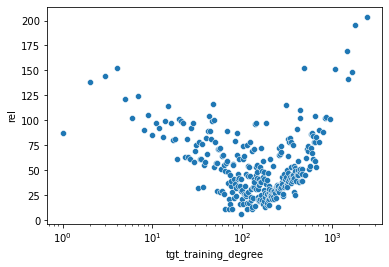

In [372]:
import seaborn as sns
disease_degrees = test_triples_dis_tail_df.groupby(['tgt_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=disease_degrees, x='tgt_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:ylabel='tgt_training_degree'>

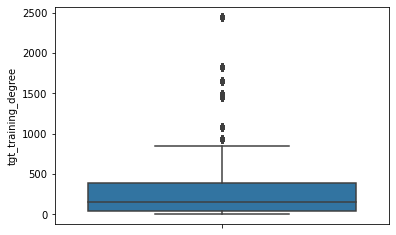

In [373]:
sns.boxplot(y=test_triples_dis_tail_df['tgt_training_degree'])

define logic

In [374]:
from pykeen.triples.triples_factory import TriplesFactory

def compute_metrics_over_triples_with_disease_tails(model_id, test_triples_w_node_degree_df, test_set_slug):#, quantiles=quantiles_map.keys()):
    col_node_degree = "tgt_training_degree" # if predicting head, this should be the 'src_training_degree'
    evaluator = RankBasedEvaluator(filtered=True)
    model_base_path = model_registry_paths.get(model_id)
    model = load_kge_model(model_base_path=model_base_path)
    print(f'loaded model from {str(model_base_path)}')
    additional_filter_triples = obtain_filtered_triples(test_type=test_set_slug,
                                                        train_triples=triples_dict[TRAIN],
                                                        valid_triples=triples_dict[VALID]
                                                       )
    test_triples_with_dis_tail_df = test_triples_w_node_degree_df.loc[test_triples_w_node_degree_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'])]
    dis_degree_values = test_triples_with_dis_tail_df[""].unique()
    result_dicts = []
    
    for degree_val in tqdm(dis_degree_values): 
        df_subset = test_triples_with_dis_tail_df.loc[test_triples_with_dis_tail_df[col_node_degree]==degree_val][[COL_SOURCE, COL_EDGE, COL_TARGET]]
        triples_subset = df_subset.values
        triples_subset = TriplesFactory.from_labeled_triples(triples_subset, 
                                                             relation_to_id=triples_dict[TRAIN].relation_to_id, 
                                                             entity_to_id=triples_dict[TRAIN].entity_to_id)
        if triples_subset.num_triples > 0:
            subset_result = evaluator.evaluate(model,
                                               triples_subset.mapped_triples, 
                                               additional_filter_triples=additional_filter_triples,
                                               use_tqdm=False)
            result_dicts.append({'dis_degree': degree_val, 'results': subset_result, 'relation': 'All', 'count': triples_subset.num_triples})
    return result_dicts



In [377]:
def extract_relevant_metrics(metric_name, results_by_node_degree_dict):
    degrees = list(results_by_node_degree_dict.keys())
    metrics = []
    for deg, metric in results_by_node_degree_dict.items():
        metrics.append(metric[metric_name])
    return degrees, metrics
    
    
def plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', 
                                                   results_by_node_degree_dict=None, 
                                                   model_id=None,
                                                   figsize=(7,7),
                                                   entity_type_examined=None,
                                                  ):

    degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dict)   
    plot, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(ax = ax, x=degrees, y=metrics)
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting {entity_type_examined} nodes Vs. {entity_type_examined} node degree | Model: {model_id}')
    #return degrees, metrics
    
    
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', 
                                                   results_by_node_degree_dicts_combined=None,
                                                   entity_type_examined=None,
                                                  ):
    result_dfs = {}
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    model_ids = result_dfs.keys()
    concatenated = pd.concat([result_dfs[model_id].assign(dataset=f'{model_id}') for model_id in model_ids])
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting {entity_type_examined} nodes Vs. {entity_type_examined} node degree | Model: {model_id}')
    #return degrees, metrics

#### predict on bioblp-d

In [36]:
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_bioblpd = compute_metrics_over_triples_with_disease_tails(model_id=MODEL_ID,
                                                                                 test_triples_w_node_degree_df=test_triples_dis_df, 
                                                                                 test_set_slug=TEST_RESTRICTED_DIS)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs


100%|██████████| 301/301 [1:13:29<00:00, 14.65s/it]


In [37]:
results_by_node_degree_dicts_bioblpd = {}
for result in results_by_node_degree_bioblpd:
         results_by_node_degree_dicts_bioblpd[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
#results_by_node_degree_dicts_bioblpd

In [38]:
WRITE_TO_FILE=False
if WRITE_TO_FILE:
    with open(f'metrics/{MODEL_ID}/node-degree-eval-new.json', 'w+') as f:
        json.dump(results_by_node_degree_dicts_bioblpd, f)


### Plots V2 - (improved 17/03) - Plotting the difference in LP scores by RotatE and BioBLP-X

In [24]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)

    
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_bioblpd = json.load(f)


In [51]:
rotate_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_rotate, orient='index')
rotate_df = rotate_df.reset_index().rename(columns={'index':'degree'})

bioblpd_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_bioblpd, orient='index')
bioblpd_df = bioblpd_df.reset_index().rename(columns={'index':'degree'})

In [247]:
merged_df = rotate_df.merge(bioblpd_df, how='inner', on='degree', suffixes=['_rotate', '_bioblpd'])
merged_df.drop(columns=['Relation_bioblpd', 'Relation_rotate', 'Count_bioblpd'], inplace=True)
merged_df = merged_df.astype({'degree':'float'})
merged_df = merged_df.rename(columns={"Count_rotate":"count"})
#merged_df = merged_df.sort_values(by='degree').reset_index()
merged_df[:3]

,degree,count,arithmetic_mean_rank_rotate,adjusted_arithmetic_mean_rank_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,arithmetic_mean_rank_bioblpd,...,hits_at_5_bioblpd,hits_at_10_bioblpd,proportion,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,464.0,46,62.108696,0.001172,0.357222,0.260870,0.413043,0.413043,0.434783,1398.347778,...,0.217391,0.239130,0.202020,-1336.239082,-0.025207,0.194544,0.152174,0.217391,0.195652,0.195652
1,56.0,72,180.361115,0.003403,0.077358,0.027778,0.069444,0.083333,0.208333,860.847229,...,0.152778,0.194444,0.333333,-680.486115,-0.012840,-0.014317,-0.013889,-0.027778,-0.069444,0.013889
2,180.0,27,26.592592,0.000502,0.179837,0.074074,0.185185,0.222222,0.444444,440.555542,...,0.259259,0.333333,0.106061,-413.962950,-0.007809,-0.023506,-0.037037,-0.074074,-0.037037,0.111111


In [ ]:

merged_df['num_unique_ents'] = merged_df['degree'].apply(lambda x: len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_dis_tail_df, 
                                                                                                                               degree=x, 
                                                                                                                               node_endpoint_type=COL_TARGET)))

In [239]:

merged_df['num_unique_ents'] = merged_df['degree'].apply(lambda x: len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_dis_tail_df, 
                                                                                                                               degree=x, 
                                                                                                                               node_endpoint_type=COL_TARGET)))

min_c, max_c, mean_c, std_c = merged_df.count.min(), merged_df.count.max(), merged_df.count.mean(), merged_df.count.std()
merged_df['proportion'] = (merged_df.count-min_c)/(max_c-min_c)
merged_df.proportion.describe()

count    301.000000
mean       0.246703
std        0.165299
min        0.000000
25%        0.126263
50%        0.202020
75%        0.343434
max        1.000000
Name: proportion, dtype: float64

In [226]:
#merged_df[merged_df['inverse_harmonic_mean_rank_bioblpd']<0.3][['inverse_harmonic_mean_rank_bioblpd', 'arithmetic_mean_rank_bioblpd', 'hits_at_10_bioblpd']]
merged_df[:2]
merged_df[merged_df['degree']==2448.0]

,degree,Relation_rotate,Count_rotate,arithmetic_mean_rank_rotate,adjusted_arithmetic_mean_rank_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,...,hits_at_5_bioblpd,hits_at_10_bioblpd,proportion,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
13,2448.0,All,204,15.328431,0.000289,0.269899,0.107843,0.313725,0.460784,0.666667,...,0.0,0.0,1.0,-2269.497497,-0.042806,0.269226,0.107843,0.313725,0.460784,0.666667


In [198]:
from nb_utils.eval_utils import EVAL_METRICS_SHORTLIST
#df_new = merged_df[['degree', 'Count_rotate']]
for metric in EVAL_METRICS_SHORTLIST:
    merged_df[metric] = merged_df[f'{metric}_rotate'] - merged_df[f'{metric}_bioblpd']

In [199]:
merged_df = merged_df.astype({'degree':'float'})

In [248]:
xx = merged_df.sort_values(by='degree')
xx[xx['degree']<10][['degree', 'count', 'arithmetic_mean_rank_rotate', 'arithmetic_mean_rank_bioblpd', 'hits_at_10_rotate', 'hits_at_10_bioblpd']]

,degree,count,arithmetic_mean_rank_rotate,arithmetic_mean_rank_bioblpd,hits_at_10_rotate,hits_at_10_bioblpd
232,1.0,87,32602.035156,916.816101,0.000000,0.080460
198,2.0,138,14139.166992,751.289856,0.007246,0.108696
73,3.0,144,7782.968750,667.208313,0.006944,0.194444
80,4.0,152,3688.430908,601.184204,0.039474,0.164474
21,5.0,121,3609.702393,672.962830,0.074380,0.190083
149,6.0,102,3401.132324,798.088257,0.049020,0.127451
222,7.0,124,1537.028198,512.399170,0.064516,0.193548
234,8.0,90,1043.922241,571.577759,0.055556,0.144444
25,9.0,105,789.623779,615.266663,0.095238,0.142857


In [245]:
[(x*198+6) for x in [0.2,0.4,0.6,0.8,1]]

[45.6, 85.2, 124.8, 164.4, 204]

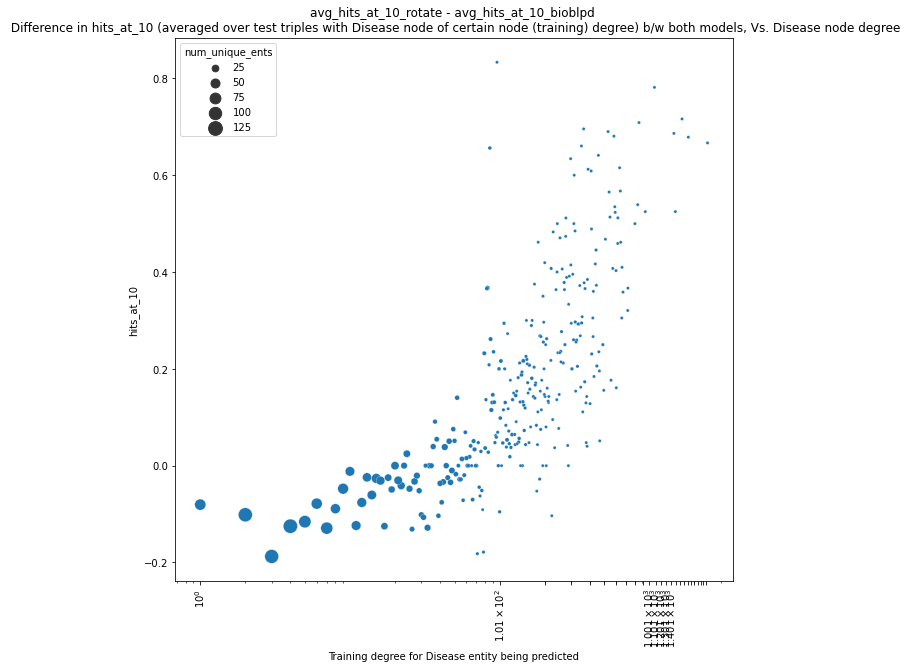

In [390]:
import matplotlib.ticker as ticker
#metric_name='inverse_harmonic_mean_rank'
metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTRIBUTE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpd \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTRIBUTE} node of certain node (training) degree) b/w both models, Vs. {ENTITY_TYPE_W_ATTRIBUTE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

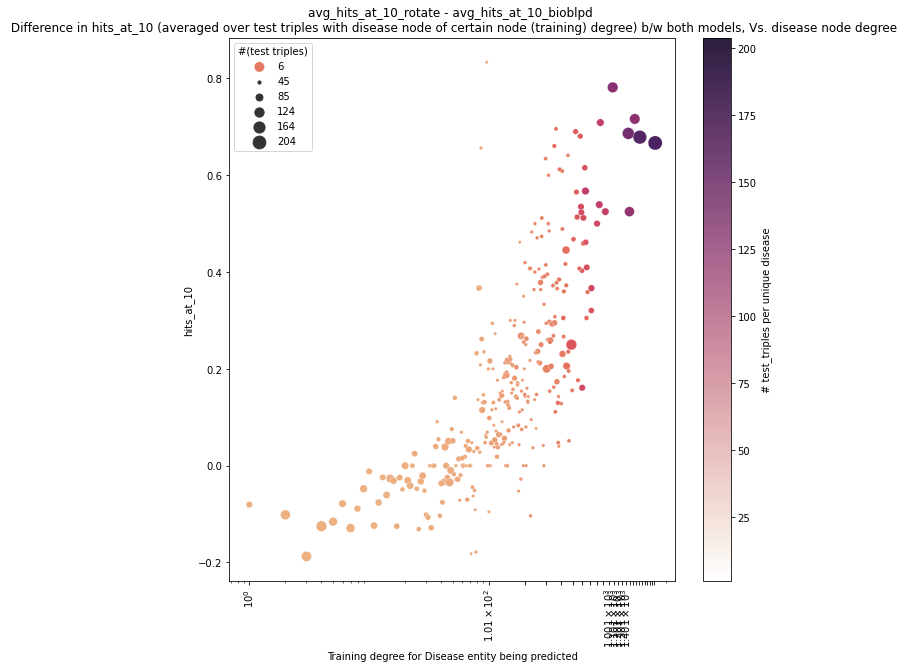

In [353]:
import matplotlib.ticker as ticker
#metric_name='inverse_harmonic_mean_rank'
metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['count']/merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
s_linear = [n*n for n in props] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=s_linear, sizes=(10,200), c=num_unique_ents, cmap='flare')
plt.xscale('log')
ax.legend(title='#(test triples)', labels = ['6', '45', '85', '124', '164', '204'])
plt.ylabel(metric_name)
plt.xlabel('Training degree for Disease entity being predicted')
plt.xticks(degrees, rotation='vertical')
#plot_.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

norm = plt.Normalize(num_unique_ents.min(), num_unique_ents.max())
cbar = ax.figure.colorbar(plt.cm.ScalarMappable(norm=norm,
                                                cmap=cmap),
                          #ticks=np.arange(num_unique_ents.min(), num_unique_ents.max() + 1),
                          label=r'# test_triples per unique disease')
d
plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpd \n Difference in {metric_name} (averaged over test triples with disease node of certain node (training) degree) b/w both models, Vs. disease node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


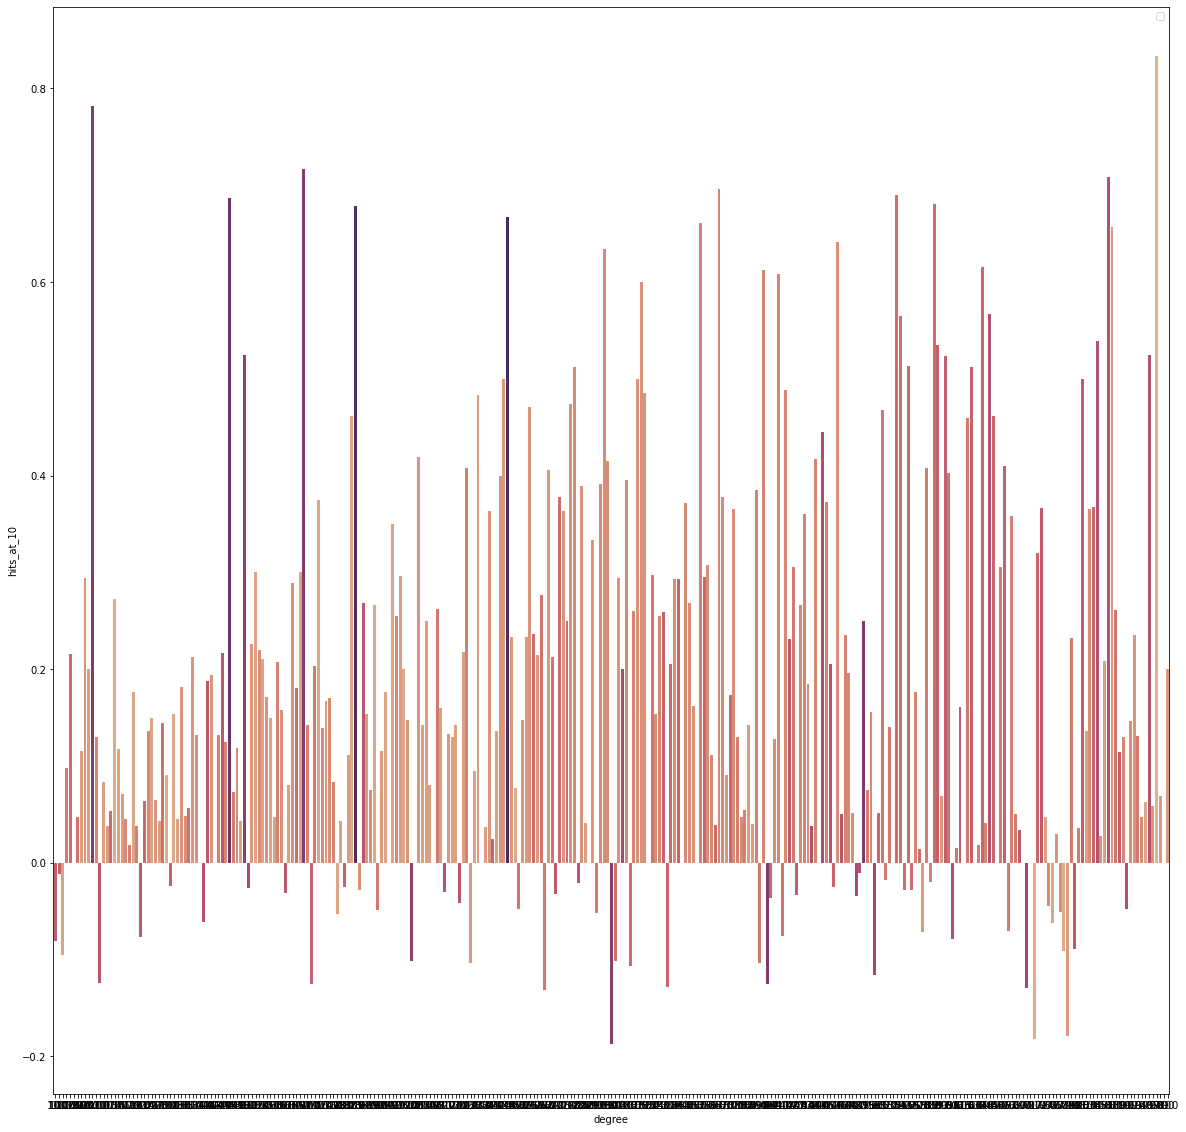

In [187]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
plot, ax = plt.subplots(figsize=(20,20))
sns.barplot(ax=ax, x=degrees, y=metrics, palette=colors_from_values(props, "flare"))
plt.legend()

### Plots V1 - Separate series plotted for BioBLP-D and RotatE

load from file

In [378]:
ENTITY_TYPE_W_ATTRIBUTE = 'Disease'
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
LOAD_FROM_FILE=False
if LOAD_FROM_FILE:
    with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
        results_by_node_degree_dicts_bioblpd = json.load(f)


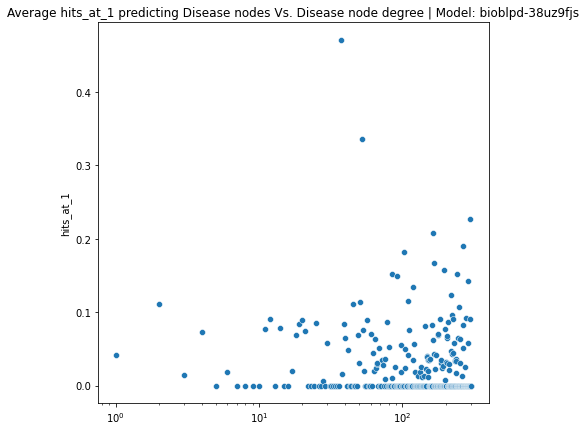

In [379]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1',
                                               model_id=MODEL_ID,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpd,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE
                                              )

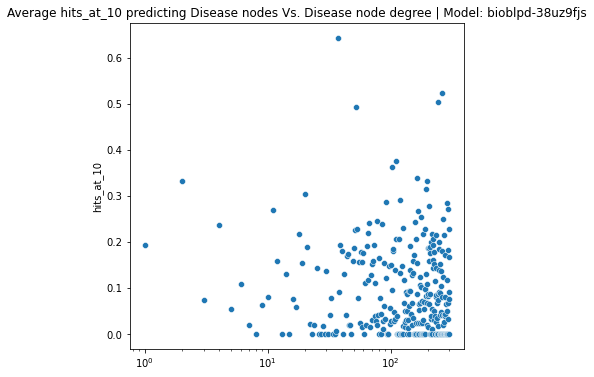

In [380]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', 
                                               model_id=MODELS.get(BIOBLP_D),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpd,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                              figsize=(6,6))

In [48]:
tags = {"model_name": MODEL_ID_bioblpd,
        "study_name": 'node_degree_trend',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, project_name='bioblp-jupyter-trial', wandb_entity='discoverylab')

In [49]:
metric_name = "hits_at_1"
degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dicts_bioblpdx)
data = [[x, y] for (x, y) in zip(degrees, metrics)]
table = wandb.Table(data=data, columns = ["degrees", "metrics"])
wandb.log({f"bioblpd-{metric_name}_node_degree" : wandb.plot.scatter(table, "degrees", "metrics")})


#### RotatE

In [36]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_rotate =  compute_metrics_over_triples_with_disease_tails(model_id=MODEL_ID,
                                                                                 test_triples_w_node_degree_df=test_triples_dis_df, 
                                                                                 test_set_slug=TEST_RESTRICTED_DIS)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb


100%|██████████| 301/301 [2:15:15<00:00, 26.96s/it]  


In [37]:
results_by_node_degree_dicts_rotate = {}
for result in results_by_node_degree_rotate:
         results_by_node_degree_dicts_rotate[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )


In [38]:
WRITE_TO_FILE=False

if WRITE_TO_FILE:
    with open(f'metrics/{MODEL_ID_rotate}/node-degree-eval-new.json', 'w+') as f:
        json.dump(results_by_node_degree_dicts_rotate, f)

load from file

In [22]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)


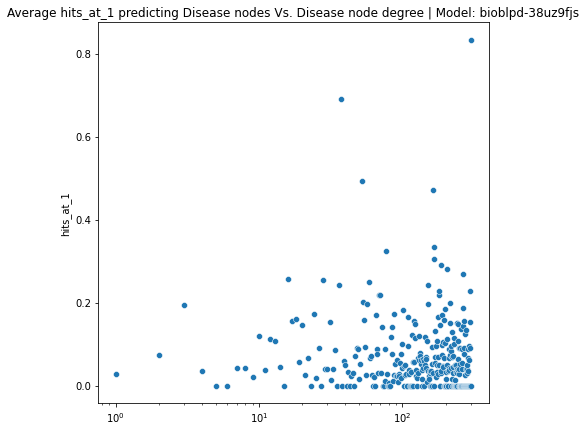

In [381]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1', 
                                               model_id=MODEL_ID,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE)

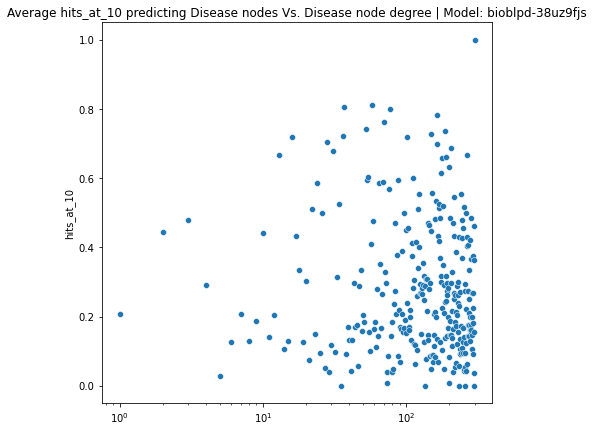

In [384]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', 
                                               model_id=MODEL_ID,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE)

### combine into one graph

In [55]:
import matplotlib.pyplot as plt
img_outdir = Path('./data/imgs/')
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', 
                                                   results_by_node_degree_dicts_combined=None,
                                                   img_outdir=img_outdir):
    result_dfs = {}
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    model_ids = list(result_dfs.keys())
    if len(model_ids)>2:
        raise ValueError("This function currently handles results from 2 models. Amend logic to handle >2 models")
    
    concatenated = pd.concat([result_dfs[model_ids[0]].assign(dataset=f'{model_ids[0]}'),
                              result_dfs[model_ids[1]].assign(dataset=f'{model_ids[1]}')])
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset', style='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | 2 Model Comparison')
    #return degrees, metr ics
    plt.savefig(img_outdir.joinpath(f"{metric_name}_vs_node_degree_{model_ids[0]}_and_{model_ids[1]}.png"))
    return concatenated

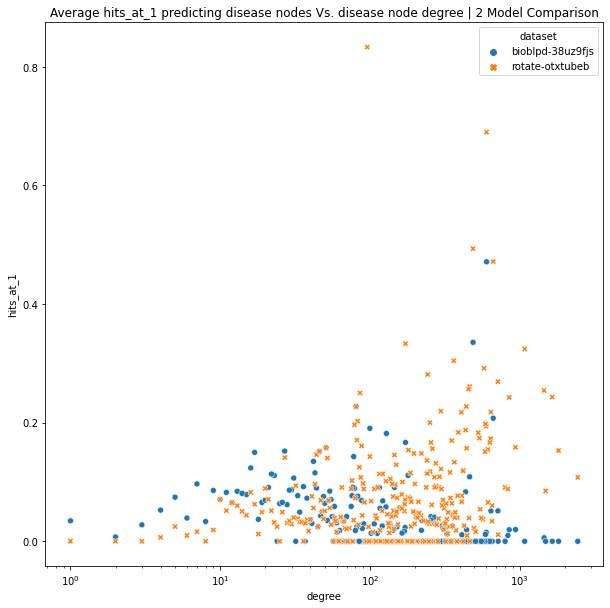

In [50]:
model_result_dicts = {MODEL_ID_rotate: results_by_node_degree_dicts_rotate,
                     MODEL_ID_bioblpd: results_by_node_degree_dicts_bioblpdx}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_1', results_by_node_degree_dicts_combined=model_result_dicts)


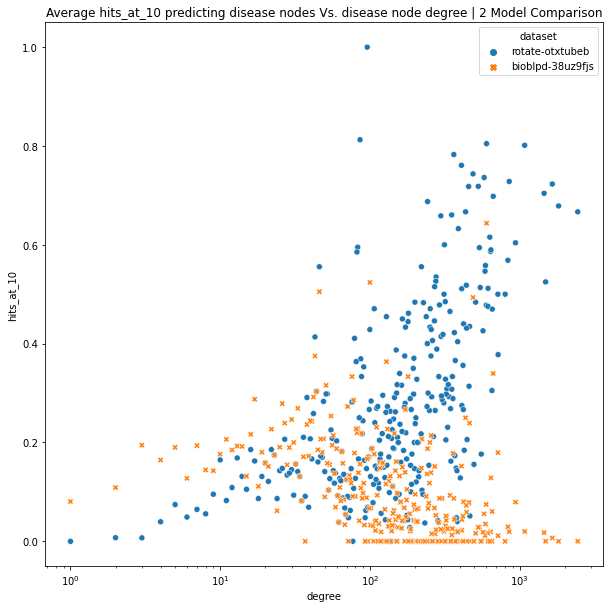

In [57]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=model_result_dicts)


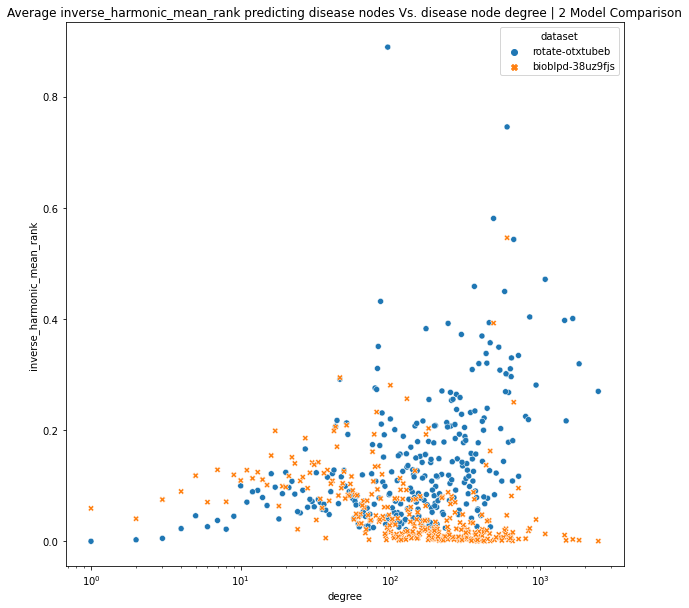

In [60]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='inverse_harmonic_mean_rank', results_by_node_degree_dicts_combined=model_result_dicts)


In [68]:
wandb.finish()

In [66]:
tags = {"model_name": MODELS.get(BIOBLP_D),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {MODELS.get(BIOBLP_D)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [67]:
degree_analysis_hits_at_1_rotate_and_bioblpd_path = "./data/imgs/hits_at_1_vs_node_degree_rotate-otxtubeb_and_bioblpd-38uz9fjs.png"
degree_analysis_hits_at_10_rotate_and_bioblpd_path = "./data/imgs/hits_at_10_vs_node_degree_rotate-otxtubeb_and_bioblpd-38uz9fjs.png"
degree_analysis_mrr_rotate_and_bioblpd_path = "./data/imgs/inverse_harmonic_mean_rank_vs_node_degree_rotate-otxtubeb_and_bioblpd-38uz9fjs.png"

wandb.log({"hits@1_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpd_path)})
wandb.log({"hits@10_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpd_path)})
wandb.log({"mrr_combined_bioblpd_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpd_path)})

In [187]:
degree_analysis_hits_at_10_bioblpd_path = "./data/imgs/node_analysis_hits_at_10_bioblpd.png"
degree_analysis_hits_at_1_bioblpd_path = "./data/imgs/node_analysis_hits_at_1_bioblpd.png"

wandb.log({"hits@10_bioblpd": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})
wandb.log({"hits@1_bioblpd": wandb.Image(degree_analysis_hits_at_1_bioblpd_path)})

## 

In [188]:
test_entity_split_by_disease_descr_path = "./data/imgs/eval_split_entity_view.png"
test_triples_split_by_disease_descr_path = "./data/imgs/eval_split_triples_view.png"
wandb.log({"Split test set entities conditioned on entity having properties with text modality": wandb.Image(test_entity_split_by_disease_descr_path)})
wandb.log({"Split test set triples conditioned on having node entities with properties of text modality": wandb.Image(test_triples_split_by_disease_descr_path)})

In [206]:
degree_analysis_hits_at_10_rotate_path = "./data/imgs/node_analysis_hits_at_10_rotate.png"
degree_analysis_hits_at_1_rotate_path = "./data/imgs/node_analysis_hits_at_1_rotate.png"

wandb.log({"hits@10_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_path)})
wandb.log({"hits@1_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_path)})

## archived

### previous stuff

How do MRR, H@k, and AMR correlate?

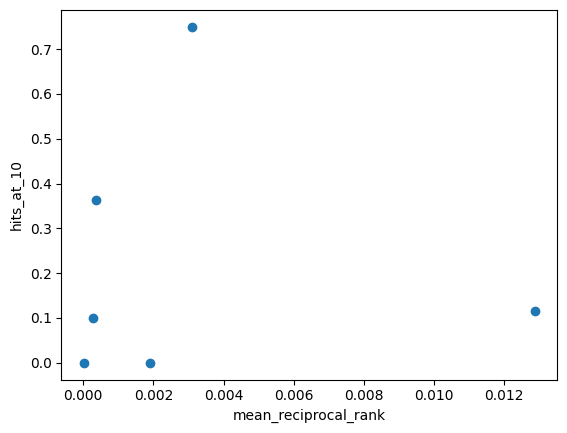

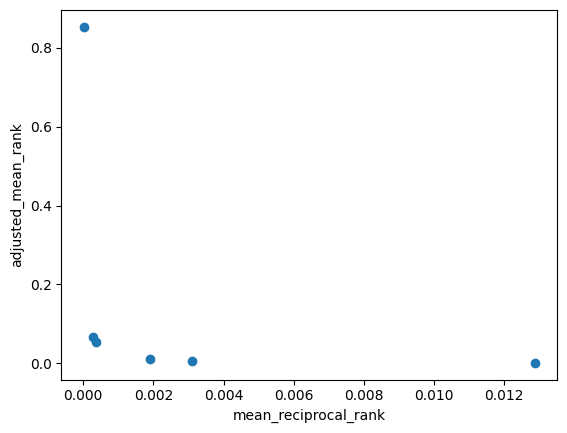

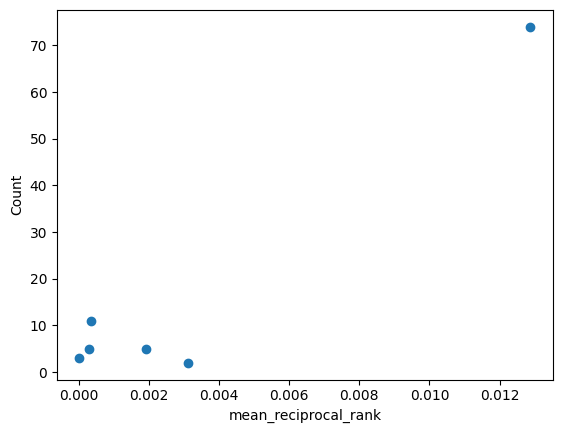

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [33]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

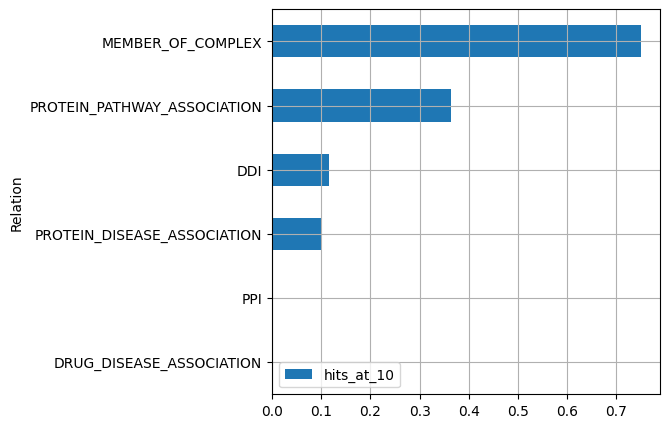

In [34]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types
The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.

In [ ]:
can you do an. analysis on degree....
compare rotate to this